# Promoter CNN Model (Sequence Only) - 5 Component Prediction

A Convolutional Neural Network that predicts 5-component probabilities from promoter sequences.
Chromosome feature has been removed to focus only on sequence information.

This notebook implements a CNN model for predicting 5-component probabilities from DNA promoter sequences, providing an end-to-end solution for:
- Data loading and preprocessing
- Model architecture definition
- Training and validation
- Performance evaluation
- Visualization of results

In [36]:
#!/usr/bin/env python3
"""
Required imports for the CNN model implementation
"""

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict, List, Any
import warnings
import time
import random
import itertools
import pickle
from datetime import datetime
from dataclasses import dataclass

warnings.filterwarnings('ignore')

@dataclass
class TrialResult:
    """Data class to store hyperparameter trial results"""
    config: Dict[str, Any]
    val_loss: float
    val_losses: List[float] = None
    train_losses: List[float] = None
    params: int = 0
    duration_s: float = 0.0
    epochs_trained: int = 0
    final_lr: float = 0.0
    cv_scores: List[float] = None
    cv_mean: float = None
    cv_std: float = None

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS available: {getattr(torch.backends, 'mps', None) is not None and torch.backends.mps.is_available()}")

PyTorch version: 2.5.1
CUDA available: False
MPS available: True


In [37]:
# Ensure project root is on sys.path for `src` imports
import sys, os
repo_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)
print('Added to sys.path:', repo_root)


Added to sys.path: /Users/jaydenthai/Dev/University Work/2025sem2/Data Science Research Project /DS-Research-Project-Tumor-Expression


## Data Processing and Dataset Class

The `PromoterDataset` class handles the preprocessing of DNA sequences:
- Encodes DNA sequences into numerical representations
- Converts sequences to one-hot encoding for CNN input
- Handles sequence length standardization

In [38]:
from src.utils.data import PromoterClassificationDataset, load_and_prepare_data_classification

## Simple CNN Model Architecture

The `PromoterCNN` class implements a lightweight convolutional neural network:

- **Input**: One-hot encoded DNA sequences (5 channels: A, T, G, C, N)
- **Architecture**: Two simple convolutional blocks + global pooling
- **Output**: 4-component probability distribution (softmax normalized)

This simplified model focuses on fast training while still capturing sequence patterns.

In [39]:
from src.models.cnn import PromoterCNN


## Data Loading and Preparation

Functions for loading the processed data and preparing it for training:

In [40]:
# Use shared loader from src for classification
from src.utils.data import load_and_prepare_data_classification as load_and_prepare_data

## Training and Validation Functions

Functions for training and validating the model:

In [41]:
from src.utils.training import (
    train_epoch_ce as train_epoch,
    validate_epoch_ce as validate_epoch,
    evaluate_model_ce as evaluate_model,
)
from src.utils.device import DeviceManager, create_device_manager

In [42]:
# Device selection with unified interface
device_manager = create_device_manager(prefer_cuda=True, verbose=True)
print(f"Using device: {device_manager.device} ({device_manager.device_name})")

# For backward compatibility with existing code
device = device_manager.device
device_name = device_manager.device_name
loader_kwargs = device_manager.loader_kwargs


Using device: mps (mps)


## Visualization and Results Analysis

Functions for plotting training results and model performance:

In [43]:
def plot_results(train_losses, val_losses, metrics):
    """Plot training results and model performance for classification"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Training curves
    axes[0].plot(train_losses, label='Train Loss', color='blue', alpha=0.7)
    axes[0].plot(val_losses, label='Validation Loss', color='red', alpha=0.7)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss (Cross-Entropy)')
    axes[0].set_title('Training Curves')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Classification metrics bar plot
    classes = [f'C{i+1}' for i in range(5)]
    axes[1].bar(classes, [metrics['per_class_accuracy'][i] for i in range(5)], color='green', alpha=0.7)
    axes[1].set_ylim(0, 1)
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Per-Class Accuracy')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('../../results/plots/cnn_results.png', dpi=300, bbox_inches='tight')
    plt.show()

## Prediction Function

Function for making predictions on new sequences:

In [44]:
def predict_component_probabilities(model, sequence: str, device_manager) -> dict:
    """Predict component probabilities for a new sequence"""
    
    model.eval()
    
    # Create temporary dataset for encoding
    temp_dataset = PromoterDataset([sequence], np.array([[0, 0, 0, 0, 0]], dtype=np.float32))
    
    # Encode sequence
    encoded_seq = temp_dataset.encode_sequence(sequence)
    
    # Convert to tensor using device manager
    sequence_tensor = device_manager.to_device(torch.FloatTensor(encoded_seq).unsqueeze(0))
    
    # Predict
    with torch.no_grad():
        logits = model(sequence_tensor)
        probs = torch.softmax(logits, dim=1)
    
    probabilities = probs.cpu().numpy()[0]
    predicted_component = int(np.argmax(probabilities) + 1)
    confidence = float(np.max(probabilities))
    
    return {
        'component_1_prob': float(probabilities[0]),
        'component_2_prob': float(probabilities[1]),
        'component_3_prob': float(probabilities[2]),
        'component_4_prob': float(probabilities[3]),
        'component_5_prob': float(probabilities[4]),
        'predicted_component': predicted_component,
        'confidence': confidence,
        'interpretation': f"Predicted Component {predicted_component} with {confidence:.1%} confidence"
    }

## Main Execution Pipeline

Now let's run the complete training and evaluation pipeline:

In [45]:
# Load data for classification
sequences, labels = load_and_prepare_data('../../data/processed/ProSeq_with_5component_analysis.csv')

# Show data statistics
print(f"\nData statistics:")
print(f"Total samples: {len(sequences)}")
print(f"Label shape: {labels.shape}")
unique, counts = np.unique(labels, return_counts=True)
print("Class distribution:", dict(zip(unique.tolist(), counts.tolist())))

print("labels: ", labels)
print("sequences[0]: ", sequences[0])



Data statistics:
Total samples: 8304
Label shape: (8304,)
Class distribution: {0: 657, 1: 2814, 2: 873, 3: 1696, 4: 2264}
labels:  [4 3 4 ... 3 0 3]
sequences[0]:  AAGCTGCACAGTCGAGCCTGCGGCTCCGCAGCCGAATAGAGCGGAAATGCCCTCTCAGGGCATCAAAGAGCAACAAGCTGCCACTGTAAGAGGGGCCCAGACCCGCAGCGATTTTCAGCACTTCCAAGGCCTGCAGGCAGCCCAGGACCCCGGTAACGACACCGAGCACCCCGCCGTCCGCGCAGTTGGTCACTGTCTCCGCTGGGGGTGGTTGGGGGAATATGCAGCGATAGCAAGGGCCACCGTCATAATGGTAGACTGTGATTTGGCCCTCGAAGCGCAAGGCACTGGCAGACACGAGGGGCCGACCCGCCAGCACACATGCGTCATTAACCAGGTAGCGAGTGGGCACGTTGTCCGAGCAGTCAGCCACCACATCATATCGGCGGACCAGGTCTAGGGCAGTGGCTGGCGTAAGGGCCTGAGTGTACGGCACGCATTCCACTGCCGAATTGAGGCGGCGCAGCGAGGCGGCGGCCGAAAAGGCCTTGGCCTGGCCAGCCAGTGCCTCGCCATGCAGCACTTGGCGGGCCAGGTTGCTCATCTCTACCACGTCATAGTCCACAAGGCCAAGGCGGCCCACGCCGGCCGCTGCCAAGT


In [46]:
# Split data (stratified by label)
train_seq, test_seq, train_labels, test_labels = train_test_split(
    sequences, labels, test_size=0.2, random_state=42, stratify=labels
)

train_seq, val_seq, train_labels, val_labels = train_test_split(
    train_seq, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

print(f"\nData splits:")
print(f"  Train: {len(train_seq)}, Val: {len(val_seq)}, Test: {len(test_seq)}")

# Create datasets
train_dataset = PromoterClassificationDataset(train_seq, train_labels)
val_dataset = PromoterClassificationDataset(val_seq, val_labels)
test_dataset = PromoterClassificationDataset(test_seq, test_labels)

# Create data loaders using device manager
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **device_manager.get_dataloader_kwargs())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, **device_manager.get_dataloader_kwargs())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **device_manager.get_dataloader_kwargs())


Data splits:
  Train: 5314, Val: 1329, Test: 1661


In [47]:
class HyperparameterTuner:
    """Comprehensive hyperparameter tuning for PromoterCNN"""
    
    def __init__(self, train_dataset, val_dataset, device_manager):
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.device_manager = device_manager
        self.device = device_manager.device  # For backward compatibility
        self.results = []
        
        # Simplified search space for basic tuning
        self.SEARCH_SPACE = {
            'depth': [1, 2, 3, 4],
            'base_channels': [16, 24, 32, 48],
            'dropout': [0.2, 0.3, 0.4, 0.5],
            'optimizer': ['adam', 'adamw'],
            'lr': [1e-3, 3e-3],
            'weight_decay': [1e-5, 1e-4],
            'batch_size': [32, 64],
            'scheduler': ['plateau', 'cosine'],
            'loss_function': ['kldiv', 'mse']
        }
    
    def create_optimizer(self, model, config):
        """Create optimizer based on configuration"""
        if config['optimizer'] == 'adam':
            return optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
        elif config['optimizer'] == 'adamw':
            return optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
        else:
            return optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    
    def create_scheduler(self, optimizer, config):
        """Create learning rate scheduler"""
        if config.get('scheduler') == 'plateau':
            return optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
        elif config.get('scheduler') == 'cosine':
            return optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
        return None
    
    def create_criterion(self, config):
        """Create loss function"""
        if config.get('loss_function') == 'kldiv':
            return nn.KLDivLoss(reduction='batchmean')
        else:
            return nn.MSELoss()
    
    def run_trial(self, config, max_epochs=25):
        """Run a single trial with given configuration"""
        try:
            # Create model
            model = PromoterCNN(
                num_blocks=config['depth'],
                base_channels=config['base_channels'],
                dropout=config['dropout'],
                num_components=5
            ).to(self.device)
            
            # Create data loaders
            train_loader = DataLoader(self.train_dataset, batch_size=config['batch_size'], shuffle=True)
            val_loader = DataLoader(self.val_dataset, batch_size=config['batch_size'], shuffle=False)
            
            # Create optimizer, scheduler, criterion
            optimizer = self.create_optimizer(model, config)
            scheduler = self.create_scheduler(optimizer, config)
            criterion = self.create_criterion(config)
            
            # Training loop
            best_val_loss = float('inf')
            for epoch in range(max_epochs):
                train_loss = train_epoch(model, train_loader, criterion, optimizer, self.device)
                val_loss = validate_epoch(model, val_loader, criterion, self.device)
                
                if scheduler:
                    if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                        scheduler.step(val_loss)
                    else:
                        scheduler.step()
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
            
            return TrialResult(
                config=config,
                val_loss=best_val_loss,
                params=sum(p.numel() for p in model.parameters()),
                epochs_trained=max_epochs
            )
        except Exception as e:
            print(f"Trial failed: {e}")
            return TrialResult(config=config, val_loss=float('inf'))
    
    def random_search(self, num_trials=10):
        """Simple random search"""
        results = []
        for i in range(num_trials):
            config = {k: random.choice(v) for k, v in self.SEARCH_SPACE.items()}
            result = self.run_trial(config)
            results.append(result)
            print(f"Trial {i+1}/{num_trials}: Loss = {result.val_loss:.6f}")
        return results

# Create a simplified tuner for basic functionality
tuner = HyperparameterTuner(train_dataset, val_dataset, device_manager)


In [48]:
# Model Training Configuration
print(f"\n📊 TRAINING CONFIGURATION")
print("="*50)

# Use simple default hyperparameters for now
# Run hyperparameter_optimization.ipynb separately to find optimal values
model_config = {
    'depth': 2,
    'base_channels': 32, 
    'dropout': 0.3,
    'lr': 1e-3,
    'weight_decay': 1e-4,
    'batch_size': 32,
    'optimizer': 'adam'
}

print(f"Architecture: depth={model_config['depth']}, channels={model_config['base_channels']}, dropout={model_config['dropout']}")
print(f"Training: lr={model_config['lr']}, weight_decay={model_config['weight_decay']}, batch_size={model_config['batch_size']}")
print(f"Optimizer: {model_config['optimizer']}")
print("\n💡 To optimize these hyperparameters, run the separate hyperparameter_optimization.ipynb notebook")



📊 TRAINING CONFIGURATION
Architecture: depth=2, channels=32, dropout=0.3
Training: lr=0.001, weight_decay=0.0001, batch_size=32
Optimizer: adam

💡 To optimize these hyperparameters, run the separate hyperparameter_optimization.ipynb notebook


In [49]:
# Skipping extensive hyperparameter tuning for this classification run
best_cfg = None
print("Skipping hyperparameter tuning phase to run a lean classification training.")


Skipping hyperparameter tuning phase to run a lean classification training.


In [50]:
# 🎯 FINAL MODEL TRAINING WITH OPTIMIZED HYPERPARAMETERS
print(f"\n" + "="*80)
print("🚀 TRAINING FINAL MODEL WITH BEST CONFIGURATION")
print("="*80)

# Apply tuned hyperparameters from comprehensive search
if 'best_cfg' in globals() and best_cfg:
    print(f"\n✅ Using optimized hyperparameters from comprehensive tuning:")
    for key, value in best_cfg.items():
        print(f"  {key}: {value}")
    
    # Extract optimized values
    model_depth = best_cfg.get('depth', 2)
    base_channels = best_cfg.get('base_channels', 32)
    tuned_dropout = best_cfg.get('dropout', 0.3)
    tuned_lr = best_cfg.get('lr', 1e-3)
    tuned_wd = best_cfg.get('weight_decay', 1e-4)
    tuned_bs = best_cfg.get('batch_size', 32)
    tuned_optimizer = best_cfg.get('optimizer', 'adam')
    tuned_scheduler = best_cfg.get('scheduler', 'plateau')
    tuned_loss_function = best_cfg.get('loss_function', 'kldiv')
else:
    print(f"\n⚠️  Using default hyperparameters (tuning not completed):")
    model_depth = 2
    base_channels = 32
    tuned_dropout = 0.3
    tuned_lr = 1e-3
    tuned_wd = 1e-4
    tuned_bs = 32
    tuned_optimizer = 'adam'
    tuned_scheduler = 'plateau'
    tuned_loss_function = 'kldiv'

# Rebuild loaders with optimized batch size
train_loader = DataLoader(train_dataset, batch_size=tuned_bs, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=tuned_bs, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=tuned_bs, shuffle=False, num_workers=0)

print(f"\n📊 Final Training Configuration:")
print(f"  Architecture: depth={model_depth}, base_channels={base_channels}, dropout={tuned_dropout}")
print(f"  Training: optimizer={tuned_optimizer}, lr={tuned_lr}, weight_decay={tuned_wd}")
print(f"  Batch size: {tuned_bs}")
print(f"  Scheduler: {tuned_scheduler}")
print(f"  Loss function: {tuned_loss_function}")



🚀 TRAINING FINAL MODEL WITH BEST CONFIGURATION

⚠️  Using default hyperparameters (tuning not completed):

📊 Final Training Configuration:
  Architecture: depth=2, base_channels=32, dropout=0.3
  Training: optimizer=adam, lr=0.001, weight_decay=0.0001
  Batch size: 32
  Scheduler: plateau
  Loss function: kldiv


In [51]:
# Create optimized model for classification
model = PromoterCNN(num_blocks=model_depth, base_channels=base_channels, dropout=tuned_dropout, num_classes=5)
model = device_manager.create_model_wrapper(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"\n🏗️  Model Architecture:")
print(f"  Total parameters: {total_params:,}")
print(f"  Depth: {model_depth} blocks")
print(f"  Base channels: {base_channels}")
print(f"  Dropout: {tuned_dropout}")
print(f"  Device: {device_manager.device} ({device_manager.device_name})")

# Training components
temp_config = {
    'optimizer': tuned_optimizer,
    'lr': tuned_lr,
    'weight_decay': tuned_wd,
    'scheduler': tuned_scheduler,
}

optimizer = tuner.create_optimizer(model, temp_config)
scheduler = tuner.create_scheduler(optimizer, temp_config)
criterion = nn.CrossEntropyLoss()

# Training configuration
num_epochs = 50  # classification typically converges faster
learning_rate = tuned_lr

print(f"\n⚙️  Training Setup:")
print(f"  Optimizer: {tuned_optimizer}")
print(f"  Learning rate: {learning_rate}")
print(f"  Weight decay: {tuned_wd}")
print(f"  Scheduler: {tuned_scheduler}")
print(f"  Loss function: cross_entropy")
print(f"  Max epochs: {num_epochs}")


🏗️  Model Architecture:
  Total parameters: 9,157
  Depth: 2 blocks
  Base channels: 32
  Dropout: 0.3
  Device: mps (mps)

⚙️  Training Setup:
  Optimizer: adam
  Learning rate: 0.001
  Weight decay: 0.0001
  Scheduler: plateau
  Loss function: cross_entropy
  Max epochs: 50


In [52]:
# 🏃‍♂️ OPTIMIZED TRAINING LOOP (Classification)
train_losses = []
val_losses = []
best_val_loss = float('inf')
bad_epochs = 0
max_bad_epochs = 10

print(f"\n🏁 Starting optimized training for {num_epochs} epochs...")
print(f"Early stopping patience: {max_bad_epochs} epochs")

start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()

    train_loss = train_epoch(model, train_loader, criterion, optimizer, device_manager.device)
    val_loss = validate_epoch(model, val_loader, criterion, device_manager.device)

    if scheduler is not None:
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)
        else:
            scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        bad_epochs = 0
        torch.save(model.state_dict(), '../../results/model_weights/best_promoter_cnn_optimized.pth')
        print(f'🎯 New best model saved! Val Loss: {best_val_loss:.6f}')
    else:
        bad_epochs += 1
        if bad_epochs >= max_bad_epochs:
            print(f"⏹️  Early stopping at epoch {epoch+1}. Best Val Loss: {best_val_loss:.6f}")
            break

    current_lr = optimizer.param_groups[0]['lr']
    epoch_time = time.time() - epoch_start

    if epoch % 5 == 0 or epoch < 10 or bad_epochs >= max_bad_epochs - 3:
        print(f'Epoch [{epoch+1:3d}/{num_epochs}] - Train: {train_loss:.6f}, Val: {val_loss:.6f}, '
              f'LR: {current_lr:.2e}, Time: {epoch_time:.1f}s, Bad: {bad_epochs}/{max_bad_epochs}')

total_training_time = time.time() - start_time
print(f"\n✅ Training completed in {total_training_time:.1f} seconds ({total_training_time/60:.1f} minutes)")
print(f"Best validation loss: {best_val_loss:.6f}")
print(f"Total epochs trained: {len(train_losses)}")


🏁 Starting optimized training for 50 epochs...
Early stopping patience: 10 epochs
🎯 New best model saved! Val Loss: 1.491574
Epoch [  1/50] - Train: 1.493432, Val: 1.491574, LR: 1.00e-03, Time: 1.8s, Bad: 0/10
🎯 New best model saved! Val Loss: 1.484680
Epoch [  2/50] - Train: 1.487047, Val: 1.484680, LR: 1.00e-03, Time: 1.7s, Bad: 0/10
Epoch [  3/50] - Train: 1.486918, Val: 1.487238, LR: 1.00e-03, Time: 1.6s, Bad: 1/10
Epoch [  4/50] - Train: 1.487168, Val: 1.486353, LR: 1.00e-03, Time: 1.7s, Bad: 2/10
🎯 New best model saved! Val Loss: 1.484406
Epoch [  5/50] - Train: 1.482534, Val: 1.484406, LR: 1.00e-03, Time: 1.7s, Bad: 0/10
🎯 New best model saved! Val Loss: 1.483645
Epoch [  6/50] - Train: 1.481263, Val: 1.483645, LR: 1.00e-03, Time: 1.6s, Bad: 0/10
Epoch [  7/50] - Train: 1.483231, Val: 1.483686, LR: 1.00e-03, Time: 1.6s, Bad: 1/10
🎯 New best model saved! Val Loss: 1.482638
Epoch [  8/50] - Train: 1.485422, Val: 1.482638, LR: 1.00e-03, Time: 1.6s, Bad: 0/10
🎯 New best model saved

In [53]:
# 📊 COMPREHENSIVE MODEL EVALUATION (Classification)
print(f"\n" + "="*80)
print("🎯 FINAL MODEL EVALUATION WITH OPTIMIZED HYPERPARAMETERS")
print("="*80)

# Load best optimized model
model.load_state_dict(torch.load('../../results/model_weights/best_promoter_cnn_optimized.pth', map_location=device_manager.device))
logits, labels_np = evaluate_model(model, test_loader, device_manager.device)
probs = torch.softmax(torch.from_numpy(logits), dim=1).numpy()
preds = probs.argmax(axis=1)

# Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
acc = accuracy_score(labels_np, preds)
report = classification_report(labels_np, preds, digits=3)
cm = confusion_matrix(labels_np, preds)

metrics = {
    'accuracy': acc,
    'per_class_accuracy': (cm.diagonal() / cm.sum(axis=1).clip(min=1)).tolist()
}

print(f"Overall Accuracy: {acc:.4f}")
print("\nClassification Report:\n", report)
print("Confusion Matrix:\n", cm)

# Model summary
print(f"\n📋 MODEL SUMMARY:")
print(f"  Architecture: {model_depth} blocks, {base_channels} base channels")
print(f"  Parameters: {total_params:,}")
print(f"  Training time: {total_training_time:.1f}s")
print(f"  Epochs trained: {len(train_losses)}")
print(f"  Final learning rate: {optimizer.param_groups[0]['lr']:.2e}")


🎯 FINAL MODEL EVALUATION WITH OPTIMIZED HYPERPARAMETERS
Overall Accuracy: 0.3384

Classification Report:
               precision    recall  f1-score   support

           0      0.000     0.000     0.000       131
           1      0.339     0.998     0.506       563
           2      0.000     0.000     0.000       175
           3      0.000     0.000     0.000       339
           4      0.000     0.000     0.000       453

    accuracy                          0.338      1661
   macro avg      0.068     0.200     0.101      1661
weighted avg      0.115     0.338     0.171      1661

Confusion Matrix:
 [[  0 131   0   0   0]
 [  0 562   0   1   0]
 [  0 175   0   0   0]
 [  0 339   0   0   0]
 [  0 453   0   0   0]]

📋 MODEL SUMMARY:
  Architecture: 2 blocks, 32 base channels
  Parameters: 9,157
  Training time: 69.0s
  Epochs trained: 41
  Final learning rate: 5.00e-04


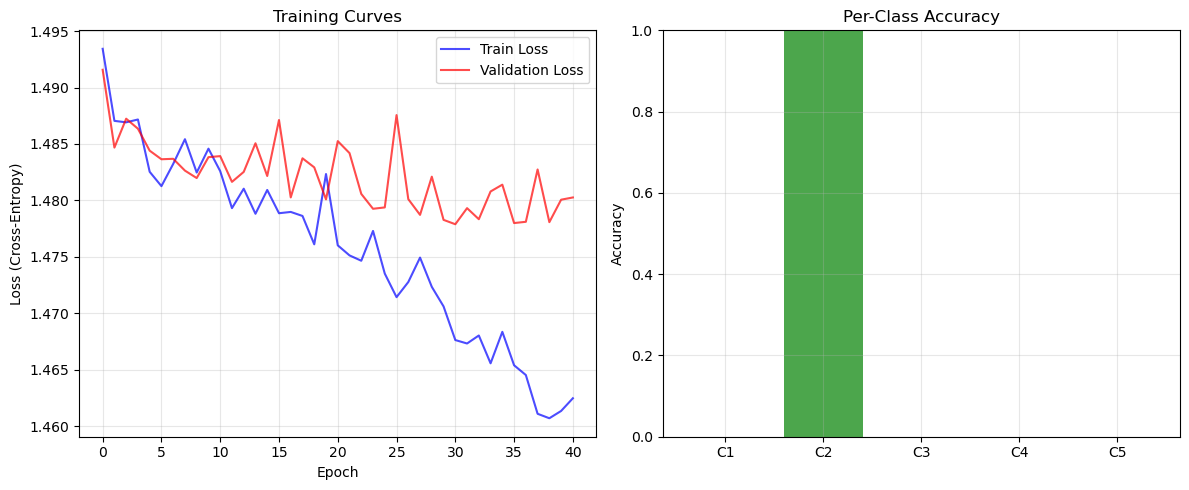

In [54]:
# Plot results
plot_results(train_losses, val_losses, metrics)

In [55]:
# Quick prediction test (classification)
print(f"\n" + "="*50)
print("TESTING PREDICTION FUNCTION")
print("="*50)

sample_seq = sequences[0]

# Encode using dataset encoder for consistency
_tmp_ds = PromoterClassificationDataset([sample_seq], np.array([0]))
encoded = device_manager.to_device(torch.FloatTensor(_tmp_ds.encode_sequence(sample_seq)).unsqueeze(0))

with torch.no_grad():
    logits = model(encoded)
    probs = torch.softmax(logits, dim=1).cpu().numpy()[0]

pred_class = int(np.argmax(probs))
conf = float(np.max(probs))

print(f"Sample sequence length: {len(sample_seq)}")
print(f"Predicted class: {pred_class} (confidence {conf:.2f})")
print(f"Class probabilities: {np.round(probs, 4)}")

print(f"\nModel saved as 'best_promoter_cnn_optimized.pth'")
print(f"Results plot saved as 'cnn_results.png'")


TESTING PREDICTION FUNCTION
Sample sequence length: 600
Predicted class: 1 (confidence 0.36)
Class probabilities: [0.0482 0.3635 0.1005 0.176  0.3118]

Model saved as 'best_promoter_cnn_optimized.pth'
Results plot saved as 'cnn_results.png'
